In [1]:
import astra
import numpy as np
import pylab


# 3d reconstruction

volume = np.load('volume.npy')

if volume.shape != (512, 512, 512):
    raise ValueError("Volume dimensions are not 512x512x512.")

In [2]:
vol_geom = astra.create_vol_geom(512, 512, 512)

angles = np.linspace(0, np.pi, 180, False)
proj_geom = astra.create_proj_geom('parallel3d', 1.0, 1.0, 512, 768, angles)

proj_id, proj_data = astra.create_sino3d_gpu(volume, proj_geom, vol_geom)

<Figure size 640x480 with 0 Axes>

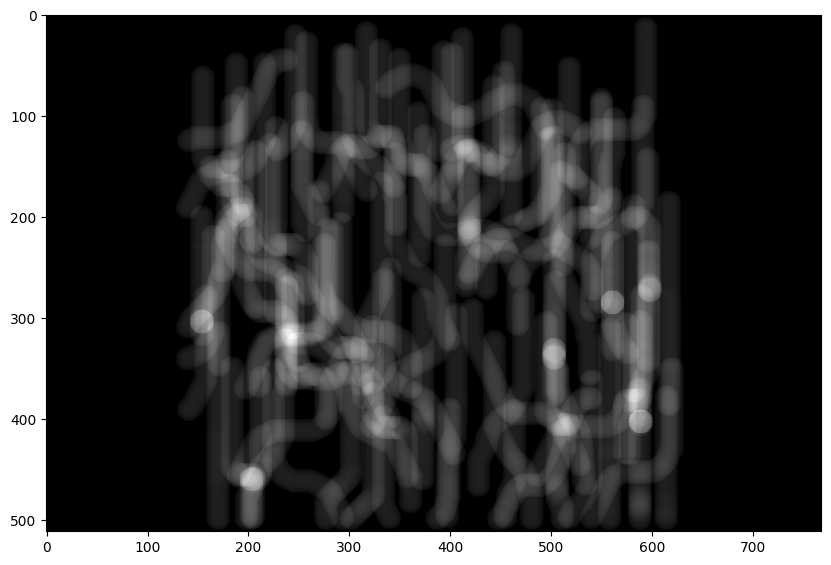

In [5]:
pylab.gray()
pylab.figure(figsize=(10, 8))
pylab.imshow(proj_data[:, int(proj_data.shape[1] / 2), :])

In [6]:
rec_id = astra.data3d.create('-vol', vol_geom)

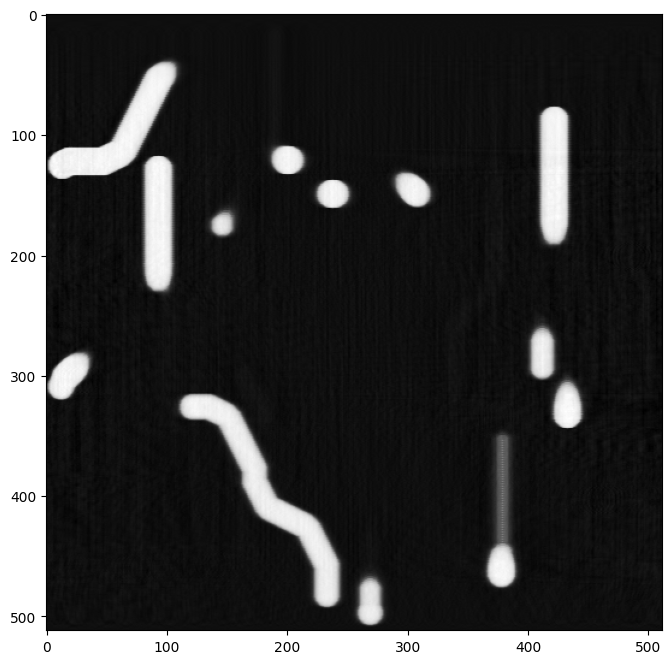

In [7]:
cfg = astra.astra_dict('SIRT3D_CUDA')
cfg['ReconstructionDataId'] = rec_id
cfg['ProjectionDataId'] = proj_id

alg_id = astra.algorithm.create(cfg)

astra.algorithm.run(alg_id, 150)

rec = astra.data3d.get(rec_id)
pylab.figure(figsize=(10, 8))
pylab.imshow(rec[:, :, 256])  
pylab.show()

astra.algorithm.delete(alg_id)
astra.data3d.delete(rec_id)
astra.data3d.delete(proj_id)


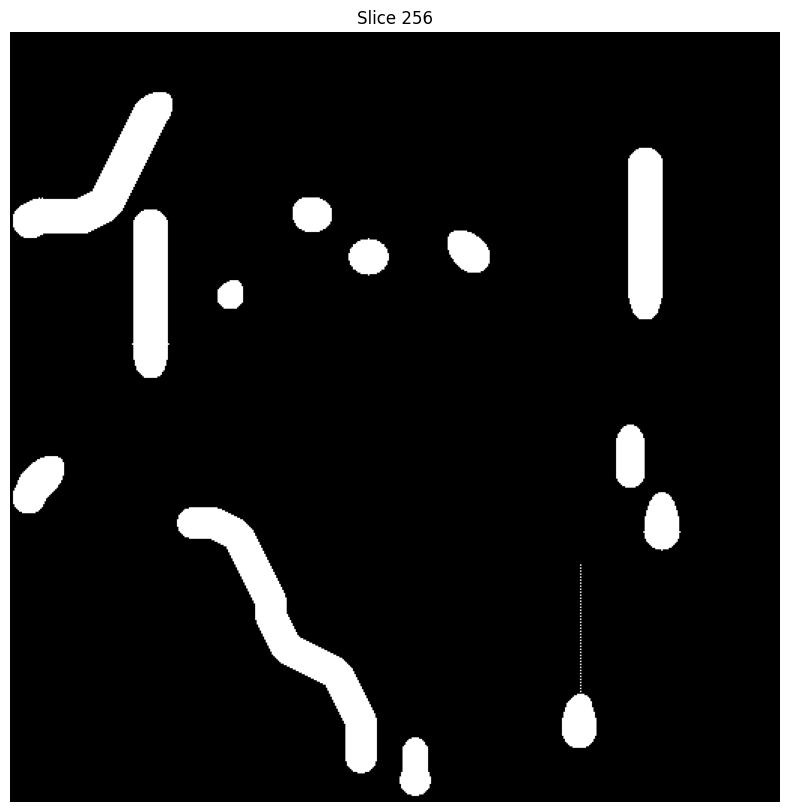

In [8]:
import numpy as np
import matplotlib.pyplot as plt

slice_256 = volume[:, :, 256]

plt.figure(figsize=(10, 10))
plt.imshow(slice_256, cmap='gray')
plt.title('Slice 256')
plt.axis('off')  
plt.show()


In [10]:
rmse = np.sqrt(np.mean((volume - rec)**2))
print(rmse)

0.05773491406842965


In [14]:
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim

psnr_value = psnr(volume, rec)

# 2D Data
slice_index = 256  
ssim_value = ssim(volume[:, :, slice_index], rec[:, :, slice_index], data_range=rec.max() - rec.min())

print(psnr_value, ssim_value)


/tmp/ipykernel_2562/1112631829.py:3: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr_value = psnr(volume, rec)


24.771229524901234 0.7887490105349058


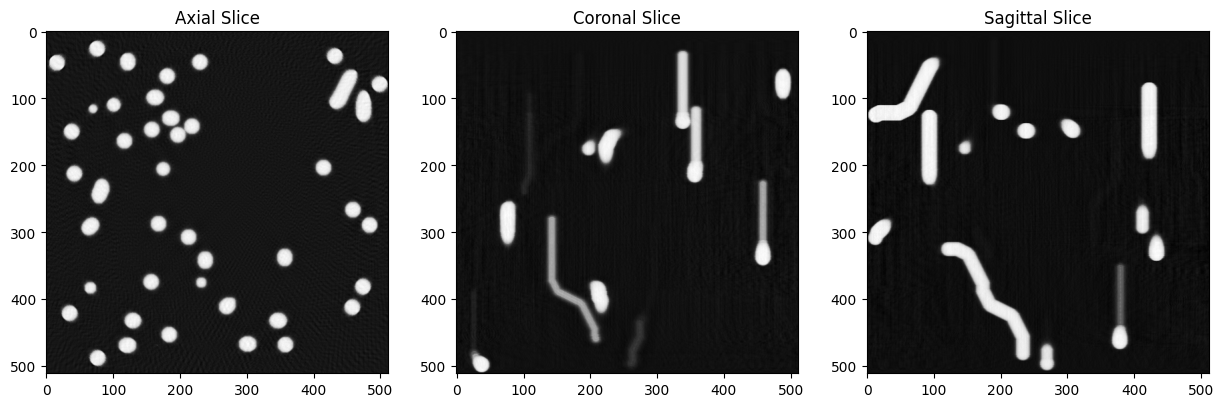

In [17]:
z_center = rec.shape[0] // 2
y_center = rec.shape[1] // 2
x_center = rec.shape[2] // 2

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(rec[z_center, :, :], cmap='gray')
axes[0].set_title('Axial Slice')

axes[1].imshow(rec[:, y_center, :], cmap='gray')
axes[1].set_title('Coronal Slice')

axes[2].imshow(rec[:, :, x_center], cmap='gray')
axes[2].set_title('Sagittal Slice')

plt.show()

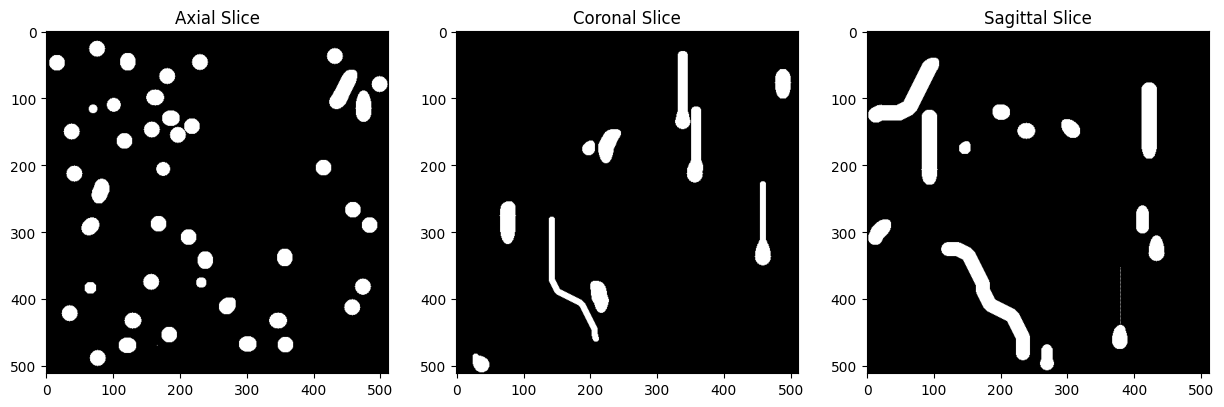

In [19]:
z_center = volume.shape[0] // 2
y_center = volume.shape[1] // 2
x_center = volume.shape[2] // 2

fig, axes = plt.subplots(1, 3, figsize=(15, 5))


axes[0].imshow(volume[z_center, :, :], cmap='gray')
axes[0].set_title('Axial Slice')

axes[1].imshow(volume[:, y_center, :], cmap='gray')
axes[1].set_title('Coronal Slice')

axes[2].imshow(volume[:, :, x_center], cmap='gray')
axes[2].set_title('Sagittal Slice')

plt.show()